In [1]:
## mostly fathon experiments on the latest code base

In [2]:
import os
import pandas as pd
import fathon
from fathon import fathonUtils as fu
import numpy as np
from collections import defaultdict

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb
###

# Plot settings
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
standard_scaler = StandardScaler()
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')
sys.path.append('/home/ak/Documents/PaperCode/stylised_facts')
import stylised_facts_data_utilities as sfd_utils
import lob_for_futures as lobfut
%matplotlib inline
import os

from scipy.stats import norm, ttest_ind

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
laptop_OS_folder = '/media/ak/OS/Data/FuturesDataSemiProcessed'
LaCie_ProcessedData = '/media/ak/LaCie/ProcessedSampledData/'
# returns_data = '/media/ak/T7/August11th2022Experiments/Returns/'
t7 = '/media/ak/T71/'
# june_ext = os.path.join(t7, 'June4th2022Experiments')
# returns_data = [f for f in os.listdir(june_ext) if '_returns' in f]
experimentsLocation = '/media/ak/T71/August11th2022Experiments/'
bars =['tick', 'volume', 'calendar', 'dollar']

In [6]:
symbol_files =[f for f in os.listdir(experimentsLocation) if str('JB1_tick') in f]
print(len(symbol_files))

138


In [7]:
file_idx = 100
file_idx_loc = os.path.join(experimentsLocation, symbol_files[file_idx])
file_idx_loc

'/media/ak/T71/August11th2022Experiments/JB1_tick_20180817_exp_df.pkl'

In [8]:
def read_exp_data(file_idx_):
    file_idx_loc_ = os.path.join(experimentsLocation, symbol_files[file_idx_])
    df_idx_ =  pd.read_pickle(file_idx_loc_)
    return df_idx_


In [34]:
dict_all_changes = dict()
for file_idx in range(0,138):
    dict_all_changes[file_idx] = read_exp_data(file_idx)['pct_change_micro_price']

In [37]:
df_all_pct_changes = pd.DataFrame.from_dict(dict_all_changes)

In [41]:
median_pct_change = df_all_pct_changes.median(axis=1).values

In [11]:
# Experimental fathon functions

In [13]:

def to_agg(data):
    return fu.toAggregated(data)

def win_Sizes_len(data):
    return round(len(to_agg(data)), -2)

class mfdfaquantities(object):
    """
 winSizes : numpy ndarray
            Array of window's sizes.
        qList : float or iterable or numpy ndarray
            List of q-orders used to compute `F`.
        polOrd : int, optional
            Order of the polynomial to be fitted in every window (default : 1).
        revSeg : bool, optional
            If True, the computation of `F` is repeated starting from the end of the time series (default : False).
"""

    def __init__(self, data, winSizes, qs, revSeg, polOrd):
        self.data = data
        self.winSizes = winSizes
        self.qs = qs 
        self.revSeg = revSeg
        self.polOrd = polOrd        
        self.pymfdfa = fathon.MFDFA(self.data)
        
    def n_F_output(self):
        """
        # F : numpy ndarray
           Returns
            -------
            numpy ndarray
                Array `n` of window's sizes.
            numpy ndarray
                qxn array `F` containing the values of the fluctuations in every window for every q-order.
        """
        n, F = self.pymfdfa.computeFlucVec(self.winSizes, self.qs, self.revSeg, self.polOrd)
        return n, F


    def H_and_H_intcpt_output(self):
        """
        listH : numpy ndarray
        # Array containing the values of the slope of the fit at every q-order.
        # fit of the fluctuation values
                Returns
            -------
            numpy ndarray
                Slope of the fit for every q-order.
            numpy ndarray
                Intercept of the fit for every q-order.


        """
        list_H, list_H_intercept = self.pymfdfa.fitFlucVec()
        return list_H, list_H_intercept


    def compute_mass_exponents(self):
        tau = self.pymfdfa.computeMassExponents()
        return tau


    def compute_multi_fractal_spectrum(self):
        alpha, mfSpect = self.pymfdfa.computeMultifractalSpectrum()
        return alpha, mfSpect

    

In [42]:

data_median = to_agg(median_pct_change)


In [43]:



winSizes_1 = fu.linRangeByStep(10,win_Sizes_len(data_median)) # rounding length of t to the nearest 100

qs = np.arange(-3, 4, 0.1)
revSeg = True
polOrd = 1


In [44]:
testClass = mfdfaquantities(data_median, winSizes_1, qs, revSeg, polOrd )


In [45]:
# need to figure out how to parallelise this better
n, F  = testClass.n_F_output()
list_H, list_H_intercept = testClass.H_and_H_intcpt_output()
tau = testClass.compute_mass_exponents()
alpha, mfSpect = testClass.compute_multi_fractal_spectrum()

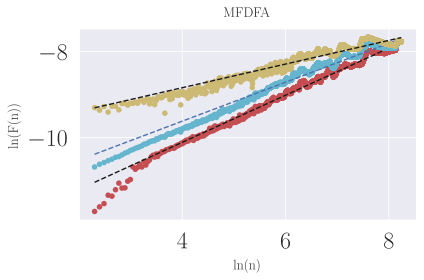

In [49]:


# list_H, list_H_intercept = pymfdfa.fitFlucVec()

plt.plot(np.log(n), np.log(F[0, :]), 'ro')

plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), 'k--', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         'b--', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), 'k--',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel("ln(n)", fontsize=14)
plt.ylabel("ln(F(n))", fontsize=14)
plt.title('MFDFA', fontsize=14)

plt.show()

# to do: format plots

No handles with labels found to put in legend.


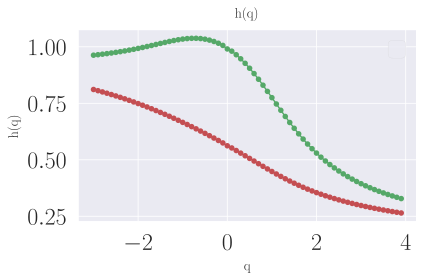

In [25]:
plt.plot(qs, list_H, 'ro-')
plt.plot(qs, list_H_2, 'go-')

plt.xlabel('q', fontsize=14)
plt.ylabel('h(q)', fontsize=14)
plt.title('h(q)', fontsize=14)
plt.legend()
plt.show()

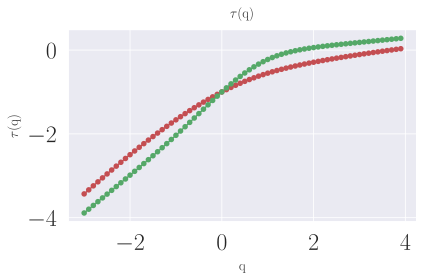

In [26]:

plt.plot(qs, tau, 'ro-')
plt.plot(qs, tau_2, 'go-')

plt.xlabel('q', fontsize=14)
plt.ylabel('$\\tau$(q)', fontsize=14)
plt.title('$\\tau$(q)', fontsize=14)
plt.show()

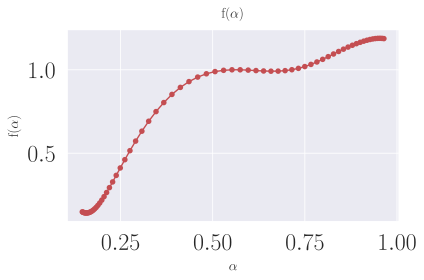

In [27]:

plt.plot(alpha, mfSpect, 'ro-')
plt.plot(alpha_2, mfSpect, 'ro-')

plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('f($\\alpha$)', fontsize=14)
plt.title('f($\\alpha$)', fontsize=14)
plt.show()